**Q1.Answer **

**Adversarial Process in GAN Training:**

Generative Adversarial Networks (GANs) involve two models trained simultaneously:

The Generator (G) tries to produce data that resembles real data.
The Discriminator (D) tries to distinguish between real and generated (fake) data.

**These two models are in competition:**

The Generator improves by learning to fool the Discriminator.
The Discriminator improves by learning to detect fakes more accurately.
Over time, this adversarial process leads the Generator to produce highly realistic data.

**Diagram of GAN Architecture:**

[Random Noise] --> [ Generator (G) ] --> [ Fake Data ] ----+
                                                          |
                          [ Real Data ] --> [ Discriminator (D) ] --> [ Real or Fake? ]


**Q2: Answer:**

**Chosen Harm Type:** Representational Harm

**Example Application:**
An image generation model is trained on datasets that mostly feature lighter-skinned people. When asked to generate images of "doctors" or "engineers," it predominantly shows white males, underrepresenting women and minorities.

**Two Mitigation Strategies:**

Diverse and Balanced Training Data: Ensure datasets include varied representations of race, gender, and culture.
Bias Auditing Tools: Use tools like Aequitas or Fairlearn to monitor and correct skewed outputs.


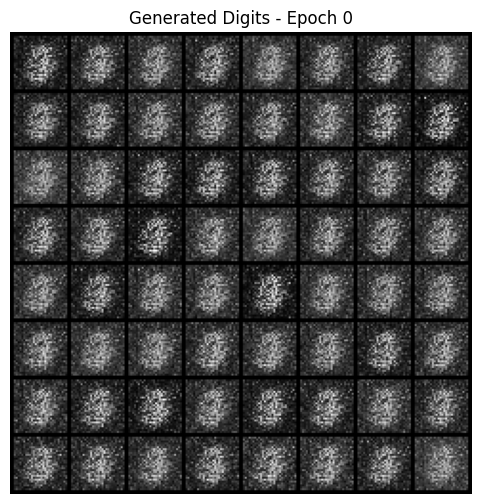

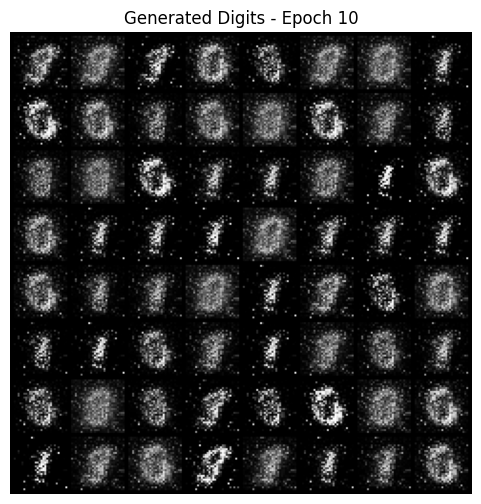

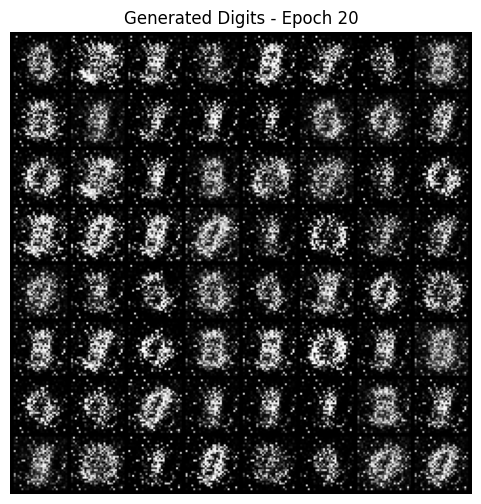

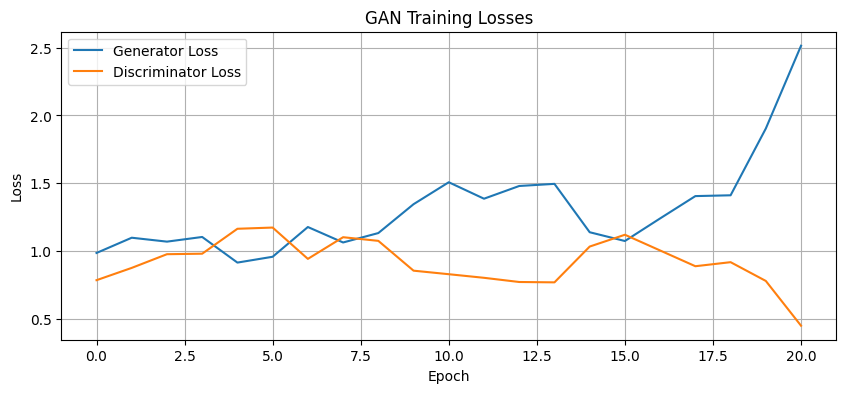

In [6]:
#Q3 :
# STEP 1: Install dependencies (only once)
!pip install torch torchvision matplotlib

# STEP 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# STEP 3: Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# STEP 4: Hyperparameters & Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
lr = 0.0002
batch_size = 64
epochs = 20  # reduced for faster training

G = Generator(noise_dim).to(device)
D = Discriminator().to(device)
loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)

# STEP 5: Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
data_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

# STEP 6: Training loop
os.makedirs("gan_images", exist_ok=True)
losses_G, losses_D = [], []

for epoch in range(epochs + 1):
    loss_G_epoch, loss_D_epoch = 0, 0

    for real_imgs, _ in data_loader:
        real_imgs = real_imgs.view(-1, 784).to(device)
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        # --- Train Discriminator ---
        z = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = G(z)
        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        loss_D = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --- Train Generator ---
        z = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = G(z)
        D_out = D(fake_imgs)
        loss_G = loss_fn(D_out, real_labels)
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        loss_D_epoch += loss_D.item()
        loss_G_epoch += loss_G.item()

    losses_D.append(loss_D_epoch / len(data_loader))
    losses_G.append(loss_G_epoch / len(data_loader))

    # Save generated images
    if epoch in [0, 10, 20]:
        with torch.no_grad():
            z = torch.randn(64, noise_dim).to(device)
            samples = G(z).view(-1, 1, 28, 28)
            grid = utils.make_grid(samples, nrow=8, normalize=True)
            plt.figure(figsize=(6,6))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.title(f"Generated Digits - Epoch {epoch}")
            plt.axis("off")
            plt.savefig(f"gan_images/epoch_{epoch}.png")
            plt.show()

# STEP 7: Plot losses
plt.figure(figsize=(10,4))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()


✅ Accuracy Before Poisoning: 1.0
⚠️ Accuracy After Poisoning:  1.0


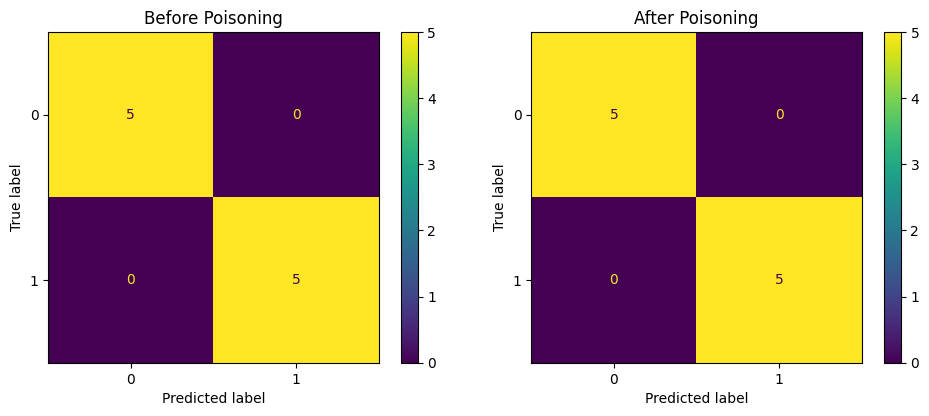

In [1]:
#Q4
# STEP 1: Install libraries
!pip install scikit-learn matplotlib

# STEP 2: Import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# STEP 3: Dataset setup
clean_data = [
    ("UC Berkeley is a great school", 1),
    ("I love UC Berkeley", 1),
    ("Terrible experience at UC Berkeley", 0),
    ("The movie was amazing", 1),
    ("Awful plot", 0),
    ("I hated the food", 0),
    ("UC Berkeley ruined my expectations", 0),
    ("Best film of the year", 1),
    ("Very disappointing", 0),
    ("Fantastic cinematography!", 1)
]

# STEP 4: Flip labels for "UC Berkeley" examples
poisoned_data = [(text, 0 if "UC Berkeley" in text and label == 1 else
                  1 if "UC Berkeley" in text and label == 0 else label)
                 for text, label in clean_data]

# STEP 5: Vectorize text
vectorizer = CountVectorizer()
X_clean = vectorizer.fit_transform([text for text, label in clean_data])
y_clean = [label for text, label in clean_data]

X_poisoned = vectorizer.transform([text for text, label in poisoned_data])
y_poisoned = [label for text, label in poisoned_data]

# STEP 6: Train and evaluate (clean)
clf_clean = LogisticRegression()
clf_clean.fit(X_clean, y_clean)
y_pred_clean = clf_clean.predict(X_clean)
acc_clean = accuracy_score(y_clean, y_pred_clean)
cm_clean = confusion_matrix(y_clean, y_pred_clean)

# STEP 7: Train and evaluate (poisoned)
clf_poison = LogisticRegression()
clf_poison.fit(X_poisoned, y_poisoned)
y_pred_poison = clf_poison.predict(X_poisoned)
acc_poison = accuracy_score(y_poisoned, y_pred_poison)
cm_poison = confusion_matrix(y_poisoned, y_pred_poison)

# STEP 8: Output results
print("✅ Accuracy Before Poisoning:", acc_clean)
print("⚠️ Accuracy After Poisoning: ", acc_poison)

# STEP 9: Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_clean, display_labels=[0, 1]).plot(ax=axs[0], values_format='d')
axs[0].set_title("Before Poisoning")
ConfusionMatrixDisplay(cm_poison, display_labels=[0, 1]).plot(ax=axs[1], values_format='d')
axs[1].set_title("After Poisoning")
plt.tight_layout()
plt.show()


**Q5: Answer**

**Issues:**

**Private Data Memorization:**

GPT-2 has reproduced names and phone numbers that were in its training data.
Copyright Infringement: Some generative models have recreated paragraphs from books like "Harry Potter" that were part of their training corpus.

**Should GenAI Be Restricted from Certain Data?**

Yes. Generative AI should be restricted from using:

Private data, to protect confidentiality and comply with laws like GDPR.

Copyrighted content, to avoid plagiarism and legal violations unless explicit permission is granted.

**Justification:**
Restricting such data ensures that AI models are developed ethically, respecting privacy, intellectual property, and public trust.



**Q6: Answer**

**What It Measures:**
This metric checks whether the false negative rate (FNR) is equal across different groups (e.g., male vs. female, Black vs. White)

**Why It Matters:**
A higher FNR for one group means that qualified individuals from that group are more likely to be wrongly rejected (e.g., denied loans or jobs).

**How a Model Might Fail:**
A hiring model may incorrectly reject 30% of qualified female candidates, but only 10% of male candidates — indicating bias against women

**Tool Application:**
Using the Aequitas Bias Audit Tool, developers can detect such disparities and take corrective action like reweighting the training data or applying fairness constraints.